In [1]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import cv2
import numpy as np
from PIL import Image
# import polars as pd
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import torch.nn.functional as F
import pytorch_warmup as warmup
import torchvision
import timeit
from tqdm import tqdm
from vit.base_vit import ViT
from vit.distillation import DinoClassifier
from dinov3.models.vision_transformer import DinoVisionTransformer
from torch.utils.tensorboard import SummaryWriter
from vit.distillation import DistillationDatasetCls 

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 16
EPOCHS = 1000
LEARNING_RATE = 1e-4
NUM_CLASSES = 100
PATCH_SIZE = 8
IMG_SIZE = 32
IN_CHANNELS = 3
# NUM_HEADS = 3
NUM_HEADS = 8
DROPOUT = 0.001
# HIDDEN_DIM = 128
HIDDEN_DIM = 256
#HIDDEN_DIM = 256
# HIDDEN_DIM = 8
ADAM_WEIGHT_DECAY = 0.01
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 4
#EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16
EMBED_DIM = 512
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
USE_SPECTRE=True
SPECTRE_THRESHOLD=1.0
EXPERIMENT_NAME="spectre_vit_fftmh16_spectrelayers_emb512_patch8"
# EXPERIMENT_NAME="spectre_vit_cifar100"
USE_DISTILLATION=False
METHOD='fft_mh_spectrelayers'
# METHOD='fft_mh'

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = SummaryWriter(f'runs/{EXPERIMENT_NAME}')
torch.serialization.add_safe_globals([DinoClassifier])
torch.serialization.add_safe_globals([DinoVisionTransformer])



In [3]:
# Test ViT
# model = ViT(IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
def export_model():
    model = ViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
                num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
                num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
                method=METHOD).to(device)
    torch.save(model, "model.pth")
    input_tensor = torch.rand((1, 3, 32, 32), dtype=torch.float32).cuda()
    torch.onnx.export(model, (input_tensor, ), "model.onnx", input_names=["input"], output_names=["output"], dynamo=True)


model = ViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
                num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
                num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
                method=METHOD).to(device)
# export_model()
if USE_DISTILLATION:
    current_dir = os.path.curdir
    DINO_REPO = f"{current_dir}/dinov3"
    BACKBONE_PATH = "/storage/experiments-ml/weights/dino/dinov3_vits16_pretrain_lvd1689m-08c60483.pth"
    dino = torch.hub.load(DINO_REPO, 'dinov3_vits16', source='local', weights=BACKBONE_PATH, skip_validation=True, map_location='cuda')
    dino.cuda().eval()
    # Freeze all parameters in the backbone
    for param in dino.parameters():
        param.requires_grad = False

    teacher = DinoClassifier(
        backbone=dino,
        num_classes=NUM_CLASSES).to(device)
    teacher.load_state_dict(torch.load('./checkpoints/dinov3s16_best.pth', weights_only=True), strict=False)
    teacher.train()
    
# Print model params number
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
# writer.add_graph(model, torch.randn(BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE).to(device))

2637581


In [4]:
#if True:
# from torchview import draw_graph
# model_graph = draw_graph(model, input_size=(BATCH_SIZE, 3, 32, 32), device='meta')
# model_graph.visual_graph

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.1149803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.3067267].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.2570148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..0.7101824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.448732

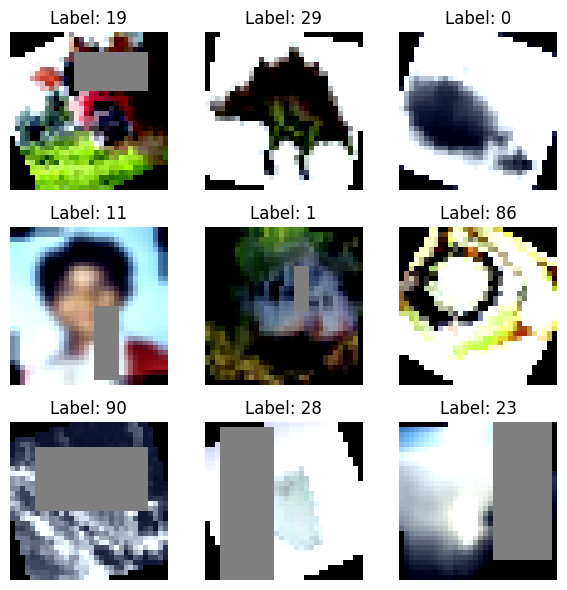

1.0
0.0


[ WARN:0@4.148] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True

In [ ]:
# Transforms
if USE_DISTILLATION:
    transform_dino = transforms.Compose([
        transforms.Resize(
            256, interpolation=transforms.InterpolationMode.BICUBIC
        ),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5071, 0.4867, 0.4408),
            std=(0.2675, 0.2565, 0.2761),
        ),
    ])

train_transform_spectre = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAffine(30),
    transforms.RandomApply([transforms.GaussianBlur(3)]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761),
    ),
    transforms.RandomErasing(0.5, inplace=True),
])

eval_transform_spectre = transforms.Compose([
    #transforms.Resize(
    #    256, interpolation=transforms.InterpolationMode.BICUBIC
    #),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761),
    ),
])

# Load CIFAR100 dataset
val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=eval_transform_spectre)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=eval_transform_spectre)
if USE_DISTILLATION:
    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
    train_dataset = DistillationDatasetCls(samples=train_dataset, teacher_tf=transform_dino, model_tf=train_transform_spectre)
else:
    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform_spectre)
    
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

# Display sample images
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    if USE_DISTILLATION:
        data = train_dataset[i]
        img = data['img_model']
        label = data['label']
    else:
        img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Save validation image
data = val_dataset[190]
img, label = data
img = img.permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.max())
print(img.min())

cv2.imwrite("inference/data/example.png", img * 255)

In [ ]:
if not USE_DISTILLATION:
    use_amp = False

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
    # optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY, nesterov=True, momentum=0.9)
    optimizer = optim.AdamW(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
    num_steps = len(train_dataloader) * EPOCHS
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
    warmup_scheduler = warmup.UntunedExponentialWarmup(optimizer)
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
    start = timeit.default_timer()
    for epoch in range(EPOCHS):
        model.train()
        train_labels = []
        train_preds = []
        train_running_loss = 0
        spectre_running_loss = 0

        for idx, img_label in enumerate(train_dataloader):
            img = img_label[0].float().to(device)
            label = img_label[1].type(torch.uint8).to(device)
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
                y_pred= model(img)
                y_pred_label = torch.argmax(y_pred, dim=1)

                train_labels.extend(label.cpu().detach())
                train_preds.extend(y_pred_label.cpu().detach())

                loss = criterion(y_pred, label)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with warmup_scheduler.dampening():
                lr_scheduler.step()


            train_running_loss += loss.item()

        train_loss = train_running_loss / (idx + 1)
        spectre_loss = spectre_running_loss / (idx + 1)

        model.eval()
        val_labels = []
        val_preds = []
        val_running_loss = 0
        with torch.no_grad():
            for idx, img_label in enumerate(val_dataloader):
                img = img_label[0].float().to(device)
                label = img_label[1].type(torch.uint8).to(device)

                y_pred= model(img)
                y_pred_label = torch.argmax(y_pred, dim=1)

                val_labels.extend(label.cpu().detach())
                val_preds.extend(y_pred_label.cpu().detach())

                loss = criterion(y_pred, label)
                val_running_loss += loss.item()


            val_loss = val_running_loss / (idx + 1)
            writer.add_scalar('Loss/Train', train_loss, epoch + 1)
            writer.add_scalar('Loss/Validation', val_loss, epoch + 1)
            writer.add_scalar('Accuracy/Train', sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels), epoch + 1)
            writer.add_scalar('Accuracy/Validation', sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels), epoch + 1)

    stop = timeit.default_timer()
    writer.add_scalar('Training time', stop - start)        
    writer.close()
    print(f"Training time: {stop - start:.2f}")


In [ ]:
if USE_DISTILLATION:
    use_amp = False
    T = 2
    soft_target_loss_weight=0.25
    ce_loss_weight=0.75

    criterion = nn.CrossEntropyLoss()
    # criterion_dist = nn.KLDivLoss(reduction="batchmean")
    criterion_dist = nn.CosineSimilarity()
    # optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
    optimizer = optim.AdamW(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
    start = timeit.default_timer()
    for epoch in range(EPOCHS):
        model.train()
        teacher.eval()
        train_labels = []
        train_preds = []
        train_running_loss = 0

        for idx, data in enumerate(train_dataloader):
            img = data['img_model'].float().to(device)
            img_teacher = data['img_teacher'].float().to(device)
            label = data['label'].type(torch.uint8).to(device)
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
                student_logits, student_feat = model(img, return_features=True)
                with torch.no_grad():
                    teacher_logits, teacher_feat = teacher(img_teacher, return_features=True)

                y_pred_label = torch.argmax(student_logits, dim=1)

                train_labels.extend(label.cpu().detach())
                train_preds.extend(y_pred_label.cpu().detach())

                soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
                soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

                soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

                #student_feat = F.normalize(student_feat, dim=-1)
                #teacher_feat = F.normalize(teacher_feat, dim=-1)

                #loss_dist = 1 - criterion_dist(student_feat, teacher_feat).mean()
                loss_ce = criterion(student_logits, label)
                loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * loss_ce

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            writer.add_scalar('Batch Loss/Train', loss.item(), epoch * len(train_dataloader) + idx)
            writer.add_scalar('Batch Loss/Dist', soft_targets_loss.item(), epoch * len(train_dataloader) + idx)
            writer.add_scalar('Batch Loss/CE', loss_ce.item(), epoch * len(train_dataloader) + idx)

            train_running_loss += loss.item()

        train_loss = train_running_loss / (idx + 1)

        model.eval()
        val_labels = []
        val_preds = []
        val_running_loss = 0
        with torch.no_grad():
            for idx, img_label in enumerate(val_dataloader):
                img = img_label[0].float().to(device)
                label = img_label[1].type(torch.uint8).to(device)

                student_logits, h_loss = model(img)
                y_pred_label = torch.argmax(student_logits, dim=1)

                val_labels.extend(label.cpu().detach())
                val_preds.extend(y_pred_label.cpu().detach())

                loss = criterion(student_logits, label) + h_loss
                val_running_loss += loss.item()


            val_loss = val_running_loss /  (idx + 1)

            writer.add_scalar('Loss/Train', train_loss, epoch + 1)
            writer.add_scalar('Loss/Validation', val_loss, epoch + 1)
            writer.add_scalar('Accuracy/Train', sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels), epoch + 1)
            writer.add_scalar('Accuracy/Validation', sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels), epoch + 1)

    stop = timeit.default_timer()
    writer.add_scalar('Training time', stop - start)
    writer.close()
    print(f"Training time: {stop - start:.2f}")